# Demo Fraud Detection

## Intro

In this notebook, we give a demo of how to use social network analysis for insurance fraud detection. 

The data for this analysis is taken from Kaggle https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis in order to ensure repreducibility. 

We are going to start with loading the necessary packages and own implementation of the methods. Afterwards, we inspect the data. With these insights, we construct the network on which we will do further analyses. 

In [1]:
from HelperFunctions import load_network
import pickle as pkl
import pandas as pd
import numpy as np
import excecute
from HelperFunctions import to_bipartite, feature_engineering
from BiRank import *
from metapath2vec import *
from stellargraph import StellarGraph
import networkx as nx
import Metrics
import scipy as sp

from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

## Data Loading

There are two sorts of patients, both of which we will use. The Inpatient data consists of patients that were admitted to the hospital, while the Outpatient data covers patients that visited the hospital, but were not admitted in it. Addtional fraud labels are present in a seperate data set. There are only fraud labels for the health care providers. Hence, we are  going to look for suspicious providers, not claims. 

In [2]:
Incoming = pd.read_csv("data/archive (1)/Train_Inpatientdata-1542865627584.csv")
Outgoing = pd.read_csv("data/archive (1)/Train_Outpatientdata-1542865627584.csv")
labels = pd.read_csv("data/archive (1)/Train-1542865627584.csv")

Below, we do a very quick inspection of the different tables, in order to have a sense of the naming of the different features, and the format in which the fraud labels are provided. 

In [3]:
Incoming.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [4]:
Outgoing.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [5]:
labels.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


All data on patients is put together in one data set. 

In [6]:
AllClaims = [Incoming, Outgoing]
AllClaims = pd.concat(AllClaims)
AllClaims.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


## Setting up the network

In order to be able to work with the network via the stellargraph package, the network data, i.e., the nodes and edges, need to be in a specific format. We need data frames for the nodes, where the nodes are the index of the data frame, and the name of this index is "ID". This is done below. 

Note that we are going to extract the data from the tables per node type. This makes it possible to take the heterogeneity of the different nodes into account. 

In [7]:
bene_nodes = AllClaims[["BeneID"]].rename(columns={"BeneID":"ID"}).drop_duplicates().set_index("ID")
claim_nodes = AllClaims[["ClaimID"]].rename(columns={"ClaimID":"ID"}).drop_duplicates().set_index("ID")
provider_nodes = AllClaims[["Provider"]].rename(columns={"Provider":"ID"}).drop_duplicates().set_index("ID")
physician_nodes = AllClaims[["AttendingPhysician"]].rename(columns={"AttendingPhysician":"ID"}).drop_duplicates().set_index("ID")

For the edges of the network, we will just take them as presented in the original data, i.e., we connect the claims with the other nodes as given in the entry. Here, the columns need to be named "source" and "target" in order for it to work. 

In [8]:
bene_claim = AllClaims[["BeneID", "ClaimID"]].rename(columns={"BeneID":"source", "ClaimID":"target"})
provider_claim = AllClaims[["Provider", "ClaimID"]].rename(columns={"Provider":"source", "ClaimID":"target"})
phys_claim = AllClaims[["AttendingPhysician", "ClaimID"]].rename(columns={"AttendingPhysician":"source", "ClaimID":"target"})
edges = pd.concat([bene_claim, provider_claim, phys_claim]).reset_index(drop=True)

With everything set up, we can easily construct the network with stellargraph. We will transform it also to networkx since it will make it easier to do some of the calculations. 

In [9]:
HG = StellarGraph({"claim": claim_nodes, "beneficiary": bene_nodes, "provider": provider_nodes, "physician": physician_nodes}, edges)

In [10]:
HG_nx = HG.to_networkx()

Below, we are going to inspect the structure of the network. 

In [11]:
print(HG.info())

StellarGraph: Undirected multigraph
 Nodes: 784241, Edges: 1674633

 Node types:
  claim: [558211]
    Features: none
    Edge types: claim-default->beneficiary, claim-default->physician, claim-default->provider
  beneficiary: [138556]
    Features: none
    Edge types: beneficiary-default->claim
  physician: [82064]
    Features: none
    Edge types: physician-default->claim
  provider: [5410]
    Features: none
    Edge types: provider-default->claim

 Edge types:
    claim-default->provider: [558211]
        Weights: all 1 (default)
        Features: none
    claim-default->physician: [558211]
        Weights: all 1 (default)
        Features: none
    beneficiary-default->claim: [558211]
        Weights: all 1 (default)
        Features: none


In [12]:
degrees = HG.node_degrees()
bene_deg = pd.Series([degrees[x] for x in list(bene_nodes.index)])
claim_deg = pd.Series([degrees[x] for x in list(claim_nodes.index)])
provider_deg = pd.Series([degrees[x] for x in list(provider_nodes.index)])
physician_deg = pd.Series([degrees[x] for x in list(physician_nodes.index)])
perc = [.25,.50,.75,.85,.95, .99] 

In [13]:
claim_deg.describe(percentiles = perc)

count    558211.0
mean          3.0
std           0.0
min           3.0
25%           3.0
50%           3.0
75%           3.0
85%           3.0
95%           3.0
99%           3.0
max           3.0
dtype: float64

In [14]:
bene_deg.describe(percentiles = perc)

count    138556.000000
mean          4.028775
std           3.229291
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
85%           7.000000
95%          11.000000
99%          15.000000
max          29.000000
dtype: float64

In [15]:
provider_deg.describe(percentiles = perc)

count    5410.000000
mean      103.181331
std       272.456989
min         1.000000
25%        10.000000
50%        31.000000
75%        87.000000
85%       152.000000
95%       421.550000
99%      1265.020000
max      8240.000000
dtype: float64

In [16]:
physician_deg.describe(percentiles = perc)

count    82064.000000
mean         6.802142
std         30.363123
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
85%          7.000000
95%         23.000000
99%         92.000000
max       2534.000000
dtype: float64

In order to be able to incorportate the fraud labels, they need to be put into 0-1. Also, the providers need to be the index of the table, and the column with fraud labels for the algorithms needs to be called "Fraud".

In [17]:
labels = labels.set_index("Provider")

In [18]:
num_labels = [0 if x == "No" else 1 for x in labels["PotentialFraud"]]
labels["Fraud"] = num_labels

In [19]:
labels

,PotentialFraud,Fraud
Provider,,
PRV51001,No,0
PRV51003,Yes,1
PRV51004,No,0
PRV51005,Yes,1
PRV51007,No,0
...,...,...
PRV57759,No,0
PRV57760,No,0
PRV57761,No,0


Since everything is now numerical, we can quickly see the relative number of fraudulent providers. Below, we see that is is around 9%.

In [20]:
labels["Fraud"].mean()

0.09353049907578559

With everything nicely set up, we can move to the calculation of the different network embeddings. 

## Network Embeddings

### Metapath2Vec

The first embedding algorithm we are going to consider is the metapath2vec method. This method walks around in the network in order to form random paths, which can be converted into an embedding using NLP methods. Here, we restrict the possible paths to a couple of metapath.

Below, one can see that each path needs to start and stop in a provider node, and that we do not allow long detours in order to get there. 

These metapaths are fed into the method, which is already implementede in its dedicated python file. 

In [21]:
metapaths = [
            ["provider", "claim", "provider"],
            ["provider", "claim","physician", "claim", "provider"],
            ["provider", "claim","beneficiary", "claim", "provider"]
            ]

In [22]:
node_ids, node_embeddings, node_targets = Metapath2vec(HG,
                                                       metapaths)

Going for a walk...
Number of random walks: 16230


With the embeddings constructed, we need to link the right embedding with the corresponding provider and hence with the corresponding fraud label. 

In [23]:
HG.nodes()

Index(['BENE11001', 'BENE11011', 'BENE11014', 'BENE11017', 'BENE11018',
       'BENE11028', 'BENE11031', 'BENE11034', 'BENE11036', 'BENE11037',
       ...
        'PRV55607',  'PRV56091',  'PRV52794',  'PRV52797',  'PRV54050',
        'PRV54302',  'PRV57762',  'PRV51577',  'PRV53083',  'PRV56377'],
      dtype='object', length=784241)

In [24]:
indices = [i for i in range(len(node_targets)) if node_targets[i]=="provider" ]
providers_sorted = [node_ids[i] for i in range(len(node_targets)) if node_targets[i]=="provider" ]

These embeddings are used to construct a fraud detection model. For this, we are going to use a gradient boosting classifier as implemented in scikit-learn. 

In [25]:
X = node_embeddings[indices]
X = pd.DataFrame(X).sort_index()
y = labels.sort_index().loc[providers_sorted]["Fraud"]

In [26]:
train_size = train_size = int(round(0.6 * len(y), 0)); train_size

3246

In [27]:
X_train = X.iloc[:train_size,:]
y_train = y[:train_size]

X_test = X.iloc[train_size:,:]
y_test = y[train_size:]

In [28]:
y_test.sum()

65

In [29]:
embedding_model = GradientBoostingClassifier(n_estimators=500,
                                                 subsample=0.8,
                                                 max_depth=3).fit(X_train, y_train)

y_pred_meta = embedding_model.predict_proba(X_test)[:, 1]

The quality of the model is analysed using the AUC, the average precision and the lift curve. 

Text(0.5, 1.0, 'AUC: 0.707')

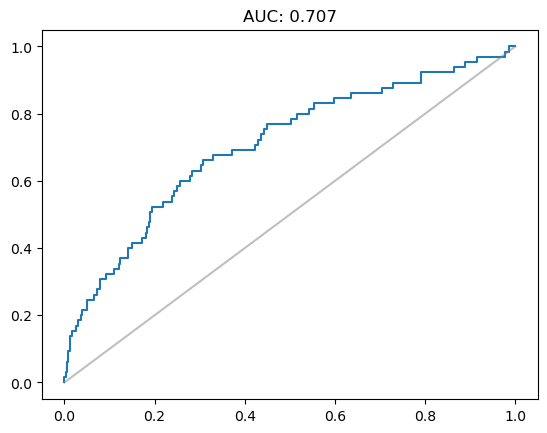

In [30]:
fpr_meta, tpr_meta, thresholds = metrics.roc_curve(y_test, y_pred_meta)
plt.plot(fpr_meta, tpr_meta)
plt.plot([0, 1], [0, 1], color="grey", alpha=0.5)
plt.title("AUC: " + str(np.round(metrics.auc(fpr_meta, tpr_meta), 3)))

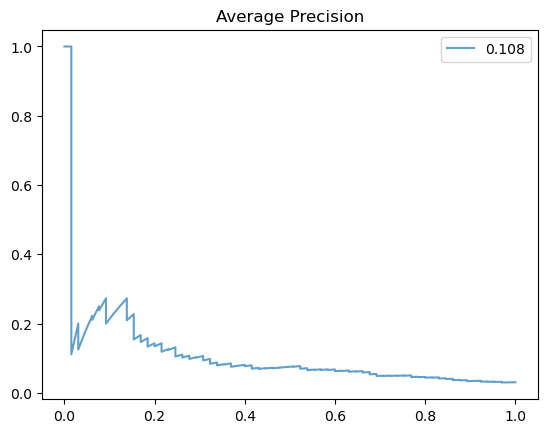

In [31]:
precision_meta, recall_meta, thresholds = metrics.precision_recall_curve(y_test,y_pred_meta)
AP_meta = np.round(metrics.average_precision_score(y_test, y_pred_meta),3)
plt.plot(recall_meta,precision_meta, label =str(AP_meta), alpha =0.7)
plt.title("Average Precision")
plt.legend()

Text(0.5, 1.0, 'Lift Curve')

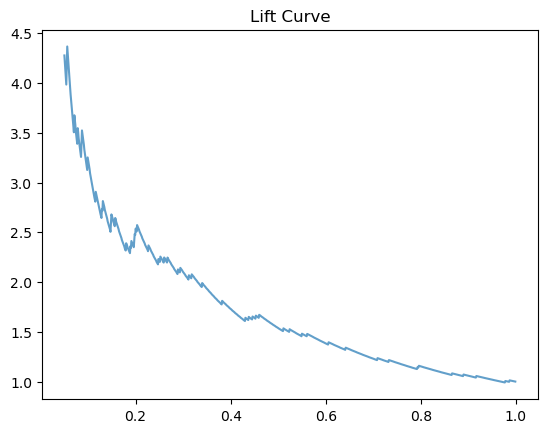

In [32]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft_meta = Metrics.lift_curve_values(y_test, y_pred_meta, steps)
plt.plot(steps, lft_meta, alpha = 0.7)

plt.title("Lift Curve")


### BiRank 

The next method is BiRank. Here, we need to reconstruct the network into a bipartite one. We do this by connecting the providers (group 1) to the corresponding physicians and beneficiaries (together group 2). We say that an edge is present between a provider and a physician/beneficiary, if the are part of the same claim. 

We need to do some simple matrix multiplications in order to obtain the correct adjacency matrix. 

In [33]:
HG_claims = HG.nodes("claim")
HG_physicians = HG.nodes("physician")
HG_providers = providers_sorted#HG.nodes("provider")
HG_beneficiaries = HG.nodes("beneficiary")

In [34]:
adj_C_Ph = HG.to_adjacency_matrix(
    list(HG_claims) + list(HG_physicians)
)[ :len(HG_claims), len(HG_claims): ]

adj_C_B = HG.to_adjacency_matrix(
    list(HG_claims) + list(HG_beneficiaries)
)[ :len(HG_claims), len(HG_claims): ]

adj_C_Pr = HG.to_adjacency_matrix(
    list(HG_claims) + list(HG_providers)
)[ :len(HG_claims), len(HG_claims): ]

In [35]:
adj_Pr_B = adj_C_Pr.transpose() @ adj_C_B
adj_Pr_Ph = adj_C_Pr.transpose() @ adj_C_Pr

adjmat_bipartite = sp.sparse.hstack((adj_Pr_B, adj_Pr_Ph))

This new bipartite adjacency matrix will now be used for the calculation of the fraud scores for the medical providers. 

The BiRank method will be applied twice in order to take the temporal aspect into account. 

In [36]:
fraud = {"FraudInd": labels["Fraud"][HG_providers].values}
fraudMat = pd.DataFrame(fraud)

provider_nodes = pd.DataFrame({"ID": HG_providers}).set_index("ID")

HG_parties = np.concatenate((HG_beneficiaries, HG_physicians))
party_nodes = pd.DataFrame({"ID": HG_parties}).set_index("ID")

ADJ = adjmat_bipartite.transpose().tocsr()

Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, provider_nodes, party_nodes, fraudMat)

Convergence reached.


In [37]:
ADJ = adjmat_bipartite.tocsr()
number_providers = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_providers))
test_set_size = number_providers-train_set_size
ADJ_train= ADJ[:train_set_size,:]
fraudMat_train = fraudMat.iloc[:train_set_size]
provider_train = provider_nodes[:train_set_size]

ADJ = ADJ_train.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, provider_train, party_nodes, fraudMat_train)

fraud_train_res = {"FraudInd": Claims_res.sort_values("ID")["ScaledScore"].values}
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_train_res = pd.DataFrame(fraud_train_res)
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, provider_nodes, party_nodes, fraudMat_test)

C:\Users\u0130626\OneDrive - KU Leuven\Documents\Research\Thesis\5. Code\Demo\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.


C:\Users\u0130626\AppData\Local\Temp\ipykernel_14060\1444531107.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)


Convergence reached.


As before, we look at the models performance using the AUC, AP and lift. 

Text(0.5, 1.0, 'AUC: 0.74')

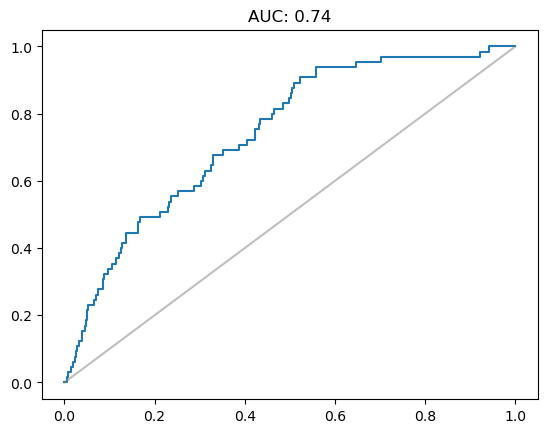

In [38]:
y_test = fraudMat.iloc[train_set_size:]["FraudInd"]
y_pred_bi = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr_bi, tpr_bi, thresholds = metrics.roc_curve(y_test,y_pred_bi)

plt.plot(fpr_bi,tpr_bi)

plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr_bi, tpr_bi),3)))

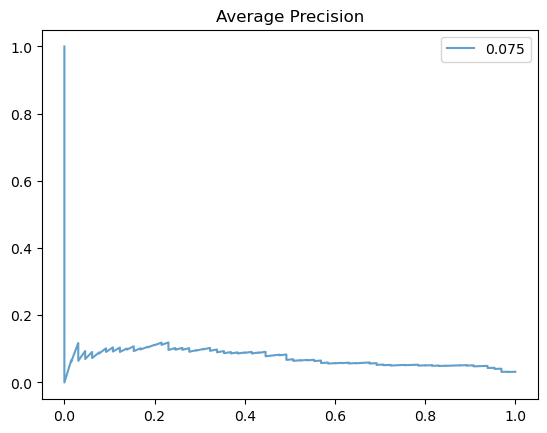

In [39]:
precision_bi, recall_bi, thresholds = metrics.precision_recall_curve(y_test,y_pred_bi)
AP_bi = np.round(metrics.average_precision_score(y_test, y_pred_bi),3)
plt.plot(recall_bi,precision_bi, label =str(AP_bi), alpha =0.7)
plt.title("Average Precision")
plt.legend()

Text(0.5, 1.0, 'Lift Curve')

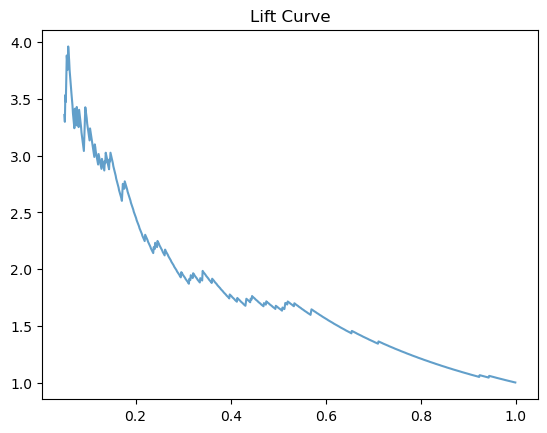

In [40]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft_bi = Metrics.lift_curve_values(y_test, y_pred_bi, steps)
plt.plot(steps, lft_bi, alpha = 0.7)

plt.title("Lift Curve")

### Traditional Network Features

The final set of features we are going to look at, are the more traditional ones. It consists of the degree and the betweenness centrality. These are also much easier to interprete than the other ones. 

We have run the code (now in text) before, and saved the results in an excel file. This saves us time when rerunning the notebook. 

As always, the model performance is analysed. 

In [41]:
#from HelperFunctions import geodesic

In [42]:
#full_geo_G = geodesic(HG_nx)

In [43]:
deg_cen = nx.degree_centrality(HG_nx)
df_degcen = pd.DataFrame({'provider': [provider for provider in provider_nodes.index],
                          'degree': [deg_cen[provider] for provider in provider_nodes.index] })
df_degcen.head()

,provider,degree
0,PRV51459,0.010507
1,PRV51574,0.005667
2,PRV53797,0.006043
3,PRV55215,0.004326
4,PRV56560,0.002949


from HelperFunctions import load_network, feature_engineering
import networkx as nx
import networkit
import pandas as pd

nx_graph_1 = HG.to_networkx()
nx_graph_2 = nx.Graph(nx_graph_1)
G_nit = networkit.nxadapter.nx2nk(nx_graph_2)

zipped_nodes = zip(nx_graph_2.nodes(), range(nx_graph_2.number_of_nodes()))
node_keys = pd.DataFrame(zipped_nodes)

cl_cen = networkit.centrality.ApproxCloseness(G_nit, 10000).run().ranking()
cl_cen_df = pd.DataFrame(cl_cen)

cl_cen_nodes = node_keys.merge(cl_cen_df, left_on = 1, right_on = 0)

cl_cen_nodes = cl_cen_nodes[["0_x", "1_y"]]
cl_cen_nodes.columns= ["node_id", "Closeness Centrality"]

btw_cen = networkit.centrality.EstimateBetweenness(G_nit, 10000).run().ranking()

btw_cen_df = pd.DataFrame(btw_cen)
btw_cen_nodes = node_keys.merge(btw_cen_df, left_on = 1, right_on = 0)
btw_cen_nodes = btw_cen_nodes[["0_x", "1_y"]]
btw_cen_nodes.columns= ["node_id", "Betweenness Centrality"]

centralities = cl_cen_nodes.merge(btw_cen_nodes, on = "node_id")
centralities.to_csv("Centralities_medical.csv", index = False)

In [44]:
Centralities_medical = pd.read_csv("Centralities_medical.csv").set_index("node_id")
Centralities_medical = Centralities_medical.loc[labels.index]

deg_cen = nx.degree_centrality(HG_nx)
df_degcen = pd.DataFrame({'provider': [provider for provider in provider_nodes.index],
                          'degree': [deg_cen[provider] for provider in provider_nodes.index] }).set_index("provider").loc[labels.index]

X = pd.merge(Centralities_medical, df_degcen, left_index = True, right_index = True).dropna().sort_index()

train_size = int(round(0.6 * len(labels), 0))

y = labels.sort_index()["Fraud"][X.index]

X_train = X.iloc[:train_size,:]
y_train = y[:train_size]

X_test = X.iloc[train_size:,:]
y_test = y[train_size:]

embedding_model = GradientBoostingClassifier(n_estimators=500,
                                                 subsample=0.8,
                                                 max_depth=3).fit(X_train, y_train)

y_pred_cen = embedding_model.predict_proba(X_test)[:, 1]

Text(0.5, 1.0, 'AUC: 0.77')

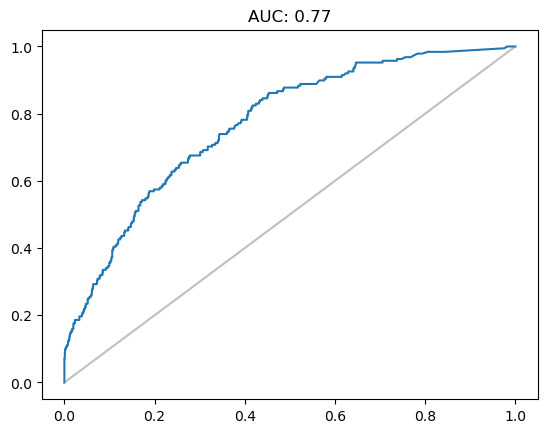

In [45]:
fpr_cen, tpr_cen, thresholds = metrics.roc_curve(y_test, y_pred_cen)
plt.plot(fpr_cen, tpr_cen)
plt.plot([0, 1], [0, 1], color="grey", alpha=0.5)
plt.title("AUC: " + str(np.round(metrics.auc(fpr_cen, tpr_cen), 3)))

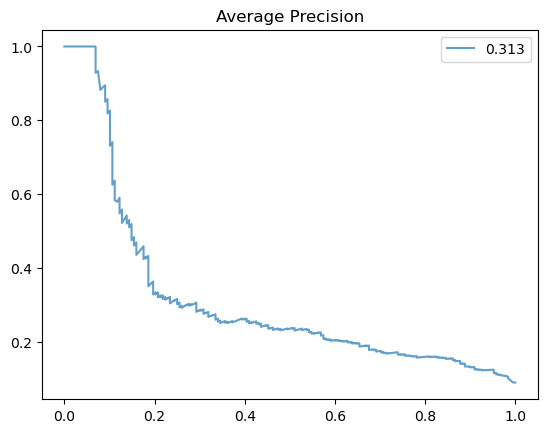

In [46]:
precision_cen, recall_cen, thresholds = metrics.precision_recall_curve(y_test,y_pred_cen)
AP_cen = np.round(metrics.average_precision_score(y_test, y_pred_cen),3)
plt.plot(recall_cen,precision_cen, label =str(AP_cen), alpha =0.7)
plt.title("Average Precision")
plt.legend()

Text(0.5, 1.0, 'Lift Curve')

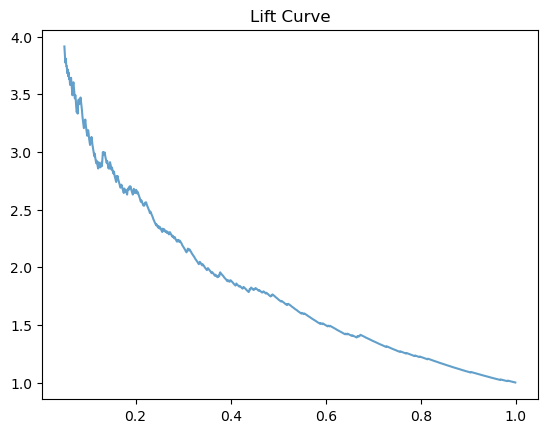

In [47]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft_cen = Metrics.lift_curve_values(y_test, y_pred_cen, steps)
plt.plot(steps, lft_cen, alpha = 0.7)

plt.title("Lift Curve")

### Putting Everything Together

This final part of the demo puts all results together. In this way, we can use the different performance metric to compare the models with each other. 

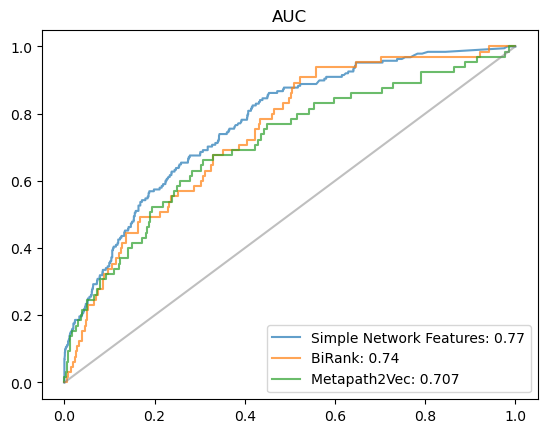

In [48]:
plt.plot(fpr_cen, tpr_cen, alpha = 0.7, label =  "Simple Network Features: " + str(np.round(metrics.auc(fpr_cen, tpr_cen), 3)))
plt.plot(fpr_bi, tpr_bi, alpha = 0.7, label =  "BiRank: " + str(np.round(metrics.auc(fpr_bi, tpr_bi), 3)))
plt.plot(fpr_meta, tpr_meta, alpha = 0.7, label =  "Metapath2Vec: " + str(np.round(metrics.auc(fpr_meta, tpr_meta), 3)))
plt.plot([0, 1], [0, 1], color="grey", alpha=0.5)
plt.title("AUC")
plt.legend()
plt.savefig("AUC_health.pdf")

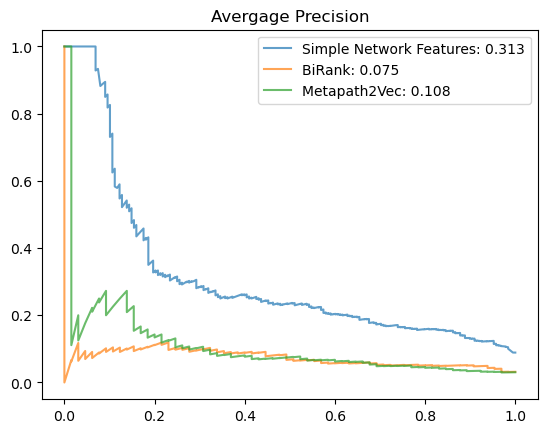

In [49]:
plt.plot(recall_cen,precision_cen, alpha = 0.7, label =  "Simple Network Features: " + str(AP_cen))
plt.plot(recall_bi,precision_bi, alpha = 0.7, label =  "BiRank: " + str(AP_bi))
plt.plot(recall_meta,precision_meta, alpha =0.7, label =  "Metapath2Vec: " + str(AP_meta))
plt.title("Avergage Precision")
plt.legend()
plt.savefig("AP_health.pdf")

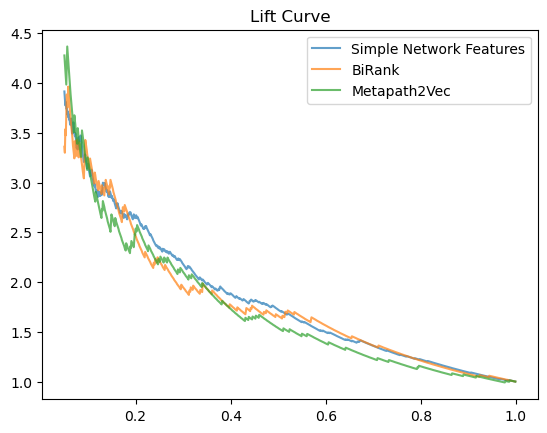

In [50]:
plt.plot(steps,lft_cen, alpha = 0.7, label =  "Simple Network Features")
plt.plot(steps,lft_bi, alpha = 0.7, label =  "BiRank")
plt.plot(steps,lft_meta, alpha =0.7, label =  "Metapath2Vec")
plt.title("Lift Curve")
plt.legend()
plt.savefig("Lift_health.pdf")

From these figures, we can conclude that the simple network features seem to be competitive and sometimes outperform the models based on more complex, and less interpretable, network embeddings. 